In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [2]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 290 (delta 113), reused 42 (delta 36), pack-reused 100 (from 1)
Receiving objects: 100% (290/290), 41.30 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [3]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches
import matplotlib.colors as mcolors
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import colors
import os
#from torch.optim.lr_scheduler import StepLRv

In [6]:
data_1 = np.load("data_array_1.npz")
data_2 = np.load("data_array_2.npz")
data_3 = np.load("data_array_3.npz")

data_array_1 = data_1['data_array']
data_array_2 = data_2['data_array']
data_array_3 = data_3['data_array']

training_data = np.concatenate((data_array_1, data_array_2), axis=0)
test_data = data_array_3
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

training data shape:  (6000, 64, 64)
test data shape:  (3423, 64, 64)


In [8]:
import math
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, BoundaryNorm

def sequential_sampling(model, masked_patches, patch_indices, sampling_strategy='argmax', plot=True):
    """
    Perform sequential sampling to reconstruct an image.

    Parameters:
    - model: The trained model used for reconstruction.
    - masked_patches: The masked patches tensor (batch_size, max_patches).
    - patch_indices: The original patch indices tensor (batch_size, max_patches).
    - sampling_strategy: The strategy to use for sampling ('argmax' for now).
    - plot: Whether to create an animation of the reconstruction process.

    Returns:
    - updates: A list of updates made during the reconstruction process.
    """
    # Initialize variables
    updates = []
    mask = (masked_patches == num_tokens - 1)  # shape: [batch_size,num_patches]
    total_num_mask = mask.sum().item()
    frames = []
    num_mask = total_num_mask
    original_masked_patches = masked_patches.clone()
    # Reconstruction loop
    for i in range(total_num_mask):
        #Get the logits of the masked patches
        logits = model(masked_patches) # (batch_size,max_patches,num_tokens - 1)
        # Isolate the masked patches
        # Get the indices of True values
        indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
        # Extract logits at masked positions while maintaining row-wise structure
        masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
        masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
        # Reshape to [batch_size, num_masked_patches, num_classes]
        masked_logits = masked_logits.view(batch_size, num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
        masked_patch_indices = masked_patch_indices.view(batch_size, num_mask) #(batch_size, current_num_mask)
        masked_probs = torch.softmax(masked_logits, dim=-1) # (batch_size,current_num_mask,num_tokens-1)

        # Sampling strategy (currently only argmax)
        if sampling_strategy == 'argmax':
            samples = torch.multinomial(masked_probs.view(-1, num_tokens-1), num_samples=1)
            # Get the probabilites of the samples
            prob_samples = torch.gather(masked_probs.view(-1, num_tokens-1), 1, samples.view(-1, 1))
            # Find the argmax
            max_prob = torch.argmax(prob_samples, dim=0)[0]
            mask_idx = torch.nonzero(mask)
            max_prob_idx = mask_idx[max_prob][-1]
            #Update
            masked_patches[0][max_prob_idx] = samples[0][max_prob]
            original_index = torch.unravel_index(max_prob_idx, (32,32))
            # update mask
            mask[0][max_prob_idx] = False
            num_mask -= 1
            # Store the masked indices, the value and the probability
            updates.append((max_prob_idx, masked_patches[0][max_prob_idx], prob_samples[max_prob][0]))
        elif sampling_strategy == 'random':
            # Random sampling
            sample_idx = np.random.randint(0, masked_probs.shape[1])
            sample = torch.multinomial(masked_probs[0][sample_idx], num_samples=1)
            mask_idx = torch.nonzero(mask)
            max_prob_idx = mask_idx[sample_idx][-1]
            masked_patches[0][max_prob_idx] = sample
            original_index = torch.unravel_index(max_prob_idx, (32,32))
            mask[0][max_prob_idx] = False
            num_mask -= 1
            updates.append((max_prob_idx, sample, masked_probs[0][sample_idx][sample]))
        elif sampling_strategy == 'autoregressive':
            # Autoregressive sampling
            # Sample the first masked value
            sample = torch.multinomial(masked_probs[0][0],num_samples=1)
            mask_idx = torch.nonzero(mask)
            max_prob_idx = mask_idx[0][-1]
            masked_patches[0][max_prob_idx] = sample
            original_index = torch.unravel_index(max_prob_idx, (32,32))
            mask[0][max_prob_idx] = False
            num_mask -= 1
            updates.append((max_prob_idx, sample, masked_probs[0][0][sample]))
        else:
            raise NotImplementedError(f"Sampling strategy '{sampling_strategy}' is not implemented.")

        if plot:
            masked_patches_vis = masked_patches.clone()
            masked_patches_vis[mask] = -1
            # Reconstruct images
            reconstructed_image = reconstruct_image_from_patches(masked_patches_vis[0])
            frames.append((reconstructed_image,updates.copy()))

    if plot:
        _plot_animation(frames, original_masked_patches, patch_indices)

    return updates

def _plot_animation(frames,masked_patches,original_patches):
    """
    Helper function to plot the reconstruction animation.

    Parameters:
    - frames: Frames for the animation.
    - original_patches: The original patches tensor (batch_size, num_patches).
    - masked_patches: The original masked patches tensor (batch_size, num_patches).
    """
    # Define the discrete colormap
    colors = ['gray', 'black', 'white']  # -1 -> gray, 0 -> black, 1 -> white
    cmap = ListedColormap(colors)
    boundaries = [-1.5, -0.5, 0.5, 1.5]
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Create the animation with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Three subplots side by side

    original_patches_vis = original_patches.clone()
    original_image = reconstruct_image_from_patches(original_patches_vis[0])

    # Display the static original and masked images
    original_ax, masked_ax, reconstructed_ax = axes
    original_ax.imshow(original_image, cmap=cmap, norm=norm, interpolation='nearest')
    original_ax.set_title("Original Image")
    for i in range(32):
        original_ax.axhline(i * 2 - 0.5, color='b', linewidth=0.5)
        original_ax.axvline(i * 2 - 0.5, color='b', linewidth=0.5)

    masked_patches_vis = masked_patches.clone()
    mask = (masked_patches == num_tokens - 1)  # shape: [batch_size,num_patches]
    masked_patches_vis[mask] = -1
    masked_image = reconstruct_image_from_patches(masked_patches_vis[0])
    masked_ax.imshow(masked_image, cmap=cmap, norm=norm, interpolation='nearest')
    masked_ax.set_title("Masked Image")
    for i in range(32):
        masked_ax.axhline(i * 2 - 0.5, color='b', linewidth=0.5)
        masked_ax.axvline(i * 2 - 0.5, color='b', linewidth=0.5)


    def update(frame):
        reconstructed_image, updates_at_frame = frame
        reconstructed_ax.clear()

        # Update the reconstructed image
        reconstructed_ax.imshow(reconstructed_image, cmap=cmap, norm=norm, interpolation='nearest')
        reconstructed_ax.set_title("Reconstructed Image")
        for i in range(32):
            reconstructed_ax.axhline(i * 2 - 0.5, color='blue', linewidth=0.5)
            reconstructed_ax.axvline(i * 2 - 0.5, color='blue', linewidth=0.5)

        # Add rectangles for the updated patches
        for update in updates_at_frame:
            original_index = torch.unravel_index(update[0], (32, 32))
            patch_value = original_patches[0][update[0]].item()
            reconstructed_value = update[1].item()

            # Determine the color of the rectangle
            color = 'green' if patch_value == reconstructed_value else 'red'

            # Add the rectangle
            rect = plt.Rectangle(
                (original_index[1] * 2 - 0.5, original_index[0] * 2 - 0.5),
                2, 2, color=color, fill=False, linewidth=2
            )
            reconstructed_ax.add_patch(rect)


    # Create the animation
    ani = FuncAnimation(fig, update, frames=frames, interval=200)

    # Save or display the animation
    ani.save(f'reconstructed_patches_animation.mp4', fps=5, dpi=150)  # Save the animation

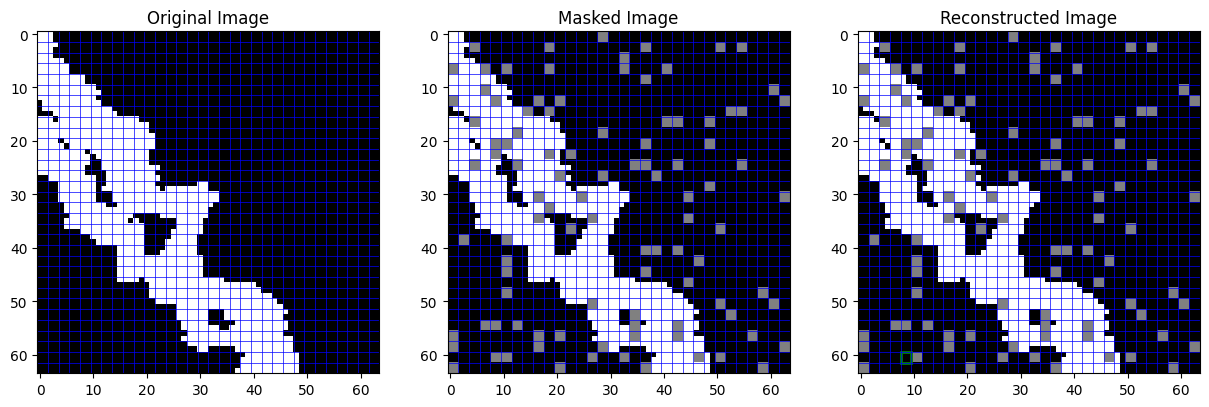

In [11]:
test_images = torch.tensor(test_data, dtype=torch.long)

# Parameters
batch_size = 1 #This must be set to 1 at the time being.
embed_dim = 4
num_heads = 2
feedforward_dim = 128
num_layers = 2
num_tokens = 17  # 16 tokens + 1 mask token
max_patches = 32 * 32
dropout = 0.2
#learning_rate = 3e-4
num_epochs = 500
hidden_dim = 32

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)

# Load the model
# Load the checkpoint
checkpoint = torch.load("vision_transformer_sample.pth", map_location=torch.device('cpu'), weights_only=True)

# Load the model weights from the checkpoint
model.load_state_dict(checkpoint["model_state_dict"])

# Set the model to evaluation mode
model.eval()
# Load the first image from the test data
# Dataset and DataLoader
current_num_mask = 100
dataset = BinaryImageDataset(test_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
batch_idx, test_images = next(enumerate(dataloader))
first_image = test_images[0]

# Preprocess images
patch_indices = torch.stack([preprocess_image(img) for img in test_images]).long() #(batch_size,max_patches)
masked_patches = patch_indices.clone() #(batch_size,max_patches)

# Generate random indices for masking
random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
# Create the mask tensor
mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
mask.scatter_(1, random_indices, True)

#Mask
masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token
masked_patches_vis = masked_patches.clone()
masked_patches_vis[mask] = -1
updates = sequential_sampling(model, masked_patches, patch_indices, sampling_strategy='random', plot=True)